In [252]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns 
from noise import pnoise2
import PIL.Image
from tqdm.auto import tqdm
from scipy.ndimage import gaussian_filter

from typing import Tuple

from IPython.core.pylabtools import print_figure
from IPython.display import Image, SVG, Math
from IPython.display import (
    display, display_html, display_png, display_svg
)


Size: (0, 1). Avg: -0.008. Range: [-0.45, 0.46]

Size: (0, 1). Avg: -0.004. Range: [-0.43, 0.34]

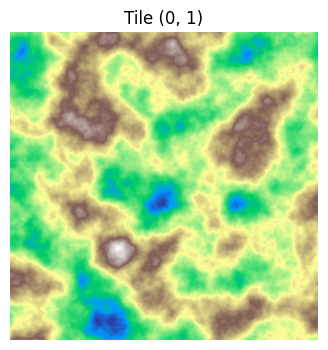

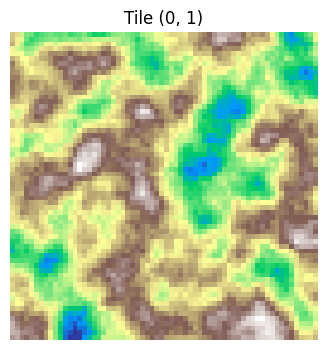

/tmp/ipykernel_192596/2694797637.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


In [224]:
class Tile():

    def __init__(self, coord: Tuple[int, int] = (0, 0), size: int = 64, scale: float = 0.06, octaves: int=12, 
                    map_seed: Tuple[float, float] = (0, 0)):

        self.size = size
        self.coord = coord
        self.scale = scale
        self.octaves = 12
        self.map_seed = map_seed

        self.grid = self.generate_base_heightmap()

    def generate_base_heightmap(self):

        x_off = self.map_seed[0] + self.coord[0] * self.size 
        y_off = self.map_seed[0] + self.coord[1] * self.size
        
        return np.array([
            [pnoise2((x + x_off) * self.scale, (y + y_off) * self.scale, octaves=self.octaves, repeatx=999999, repeaty=999999)
            for x in range(self.size)]
            for y in range(self.size)
        ])

    @staticmethod
    def blend_edges(heightmap, north=None, west=None, blend_width=5):
        if north is not None:
            heightmap[0, :] = north
            for i in range(1, blend_width):
                alpha = i / blend_width
                heightmap[i, :] = (1 - alpha) * north + alpha * heightmap[i, :]
        if west is not None:
            heightmap[:, 0] = west
            for i in range(1, blend_width):
                alpha = i / blend_width
                heightmap[:, i] = (1 - alpha) * west + alpha * heightmap[:, i]
        return heightmap

    def _repr_html_(self) -> str:
        html = f"Size: {self.coord}. Avg: {np.mean(self.grid):.3f}. Range: [{np.min(self.grid):.2f}, {np.max(self.grid):.2f}]"
        return html

    def _repr_json_(self) -> dict:
        return {"size": self.coord, "grid": self.grid.tolist()}

    def _figure_data(self, format):
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(self.grid, cmap='terrain')
        ax.set_title(f"Tile {self.coord}")
        ax.axis('off')
        data = print_figure(fig, format)
        plt.close(fig)
        return data

    def _repr_png_(self):
        return self._figure_data('png')

    def _repr_svg_(self) -> str:
        raise NotImplementedError
        
    def save_tile_as_png(self, path: str, colormap='terrain'):

        array = self.grid

        """Save a 2D float array as an RGB image using a matplotlib colormap."""
        # Normalize array to [0,1]
        norm_array = (array - np.min(array)) / (np.ptp(array) + 1e-8)

        # Apply colormap and strip alpha
        cmap = cm.get_cmap(colormap)
        rgba = cmap(norm_array)  # shape (H, W, 4), float64
        rgb = (rgba[:, :, :3] * 255).astype(np.uint8)  # Convert to 8-bit

        assert rgb.shape[:2] == array.shape, "Output size mismatch!"

        # Create and save image
        im = PIL.Image.fromarray(rgb, mode='RGB')
        im.save(path)

t = Tile(size=1024, scale=0.004, 
            coord=(0, 1), map_seed=(100, 100))
t2 = Tile(coord=(0, 1), map_seed=(100, 100))

display_html(t)
display_html(t2)

display_png(t)
display_png(t2)

t.save_tile_as_png(path="out.png")


In [265]:
class WaterSimulator:
    def __init__(self, elevation: np.ndarray, wind_dir: str = 'west'):
        """Initialize with an elevation map and prevailing wind direction."""
        self.elevation = elevation.copy()
        self.wind_dir = wind_dir
        self.precipitation = self.compute_precipitation()
        self.water = np.zeros_like(self.elevation)
        self.erosion_map = np.zeros_like(self.elevation)
        self.total_erosion = np.zeros_like(self.elevation)
        self.routed_water = np.zeros((*self.elevation.shape, 4))  # Add direction axis
        self._plot_initial_state()

        self.e_min, self.e_max = np.min(self.elevation), np.max(self.elevation)

    def compute_precipitation(self) -> np.ndarray:
        """Simulate precipitation based on wind direction, elevation, and dew point."""
        def rotate(array, k): return np.rot90(array, k=k)
        def unrotate(array, k): return np.rot90(array, k=-k)

        wind_rotation = {'west': 0, 'north': 1, 'east': 2, 'south': 3}.get(self.wind_dir, 0)

        elev = rotate(self.elevation, wind_rotation)
        H, W = elev.shape
        dew_point = 0.4
        humidity = np.ones(H)
        precipitation_rot = np.zeros((H, W))

        for x in range(W):
            slope = elev[:, x] - elev[:, x - 1] if x > 0 else np.zeros(H)
            rainfall = np.zeros(H)
            for y in range(H):
                if elev[y, x] > dew_point and slope[y] > 0:
                    rainfall[y] = slope[y] * humidity[y]
                    humidity[y] = max(humidity[y] - rainfall[y], 0.0)
            precipitation_rot[:, x] = rainfall

        return unrotate(precipitation_rot, wind_rotation)

    def route_water(self, max_iters: int = 200, tolerance: float = 1e-4):
        """Distribute water based on local terrain and pooling effects."""
        self.water = self.precipitation.copy()
        self.routed_water = np.zeros((*self.elevation.shape, 4))  # Track outflow per direction
        self.flow_velocity = np.zeros_like(self.elevation)

        kernel_offsets = [(-1, 0), (1, 0), (0, 1), (0, -1)]  # N, S, E, W
        H, W = self.elevation.shape

        for _ in range(max_iters):
            total_height = self.elevation + self.water
            delta = np.zeros((H, W, 4))
            flow = np.zeros((H, W, 4))

            for i, (dy, dx) in enumerate(kernel_offsets):
                shifted = np.roll(np.roll(total_height, dy, axis=0), dx, axis=1)
                diff = total_height - shifted
                diff[diff < 0] = 0  # Only flow downhill
                delta[:, :, i] = diff

            total_diff = np.sum(delta, axis=-1, keepdims=True)
            total_diff[total_diff == 0] = 1e-8  # Prevent divide by zero

            flow = self.water[:, :, None] * (delta / total_diff)

            new_water = self.water.copy()
            for i, (dy, dx) in enumerate(kernel_offsets):
                outflow = flow[:, :, i]
                inflow = np.roll(np.roll(outflow, -dy, axis=0), -dx, axis=1)
                new_water -= outflow
                new_water += inflow
                self.routed_water[:, :, i] += outflow  # Accumulate directional outflow

            moved = np.sum(np.abs(self.water - new_water))
            self.water = new_water

            if moved < tolerance:
                break

        self.water = np.clip(self.water, 0.0, None)
        self.flow_velocity = np.sum(flow, axis=-1)


    def calculate_velocity(self):
        """Estimate velocity as cumulative water outflow per pixel."""
        return self.flow_velocity

    def apply_erosion(self, erosion_strength=0.001, max_erosion_per_step=0.05):
        """Erode based on actual water outflow per pixel."""
        # Sum water that left each pixel
        net_outflow = np.sum(self.routed_water, axis=0) if self.routed_water.ndim == 3 else self.routed_water
        norm_outflow = net_outflow / (np.max(net_outflow) + 1e-8)

        # Erosion proportional to flow leaving pixel
        erosion = norm_outflow * erosion_strength
        erosion = np.minimum(erosion, max_erosion_per_step)

        # Optionally smooth to reduce artifacts
        erosion = gaussian_filter(erosion, sigma=1.5)

        self.erosion_map = erosion
        self.elevation -= erosion
        self.total_erosion += erosion

    def step(self):
        """Perform one rain event: precipitate → route water → erosion."""
        self.route_water()
        self.apply_erosion()

    def get_results(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        return self.elevation, self.water, self.erosion_map

    def _figure_data(self, format):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].imshow(self.elevation, cmap='terrain')
        axes[0].set_title("Elevation")
        axes[0].axis('off')
        axes[1].imshow(self.erosion_map, cmap='Blues')
        axes[1].set_title("Erosion")
        axes[1].axis('off')
        data = print_figure(fig, format)
        plt.close(fig)
        return data

    def _repr_png_(self):
        return self._figure_data('png')

    def _plot_initial_state(self):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].imshow(self.elevation, cmap='terrain')
        axes[0].set_title("Initial Elevation")
        axes[0].axis('off')
        axes[1].imshow(self.precipitation, cmap='Blues')
        axes[1].set_title("Precipitation")
        axes[1].axis('off')
        plt.tight_layout()
        plt.show()

    def plot_current_state(self):
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        axes[0].imshow(self.elevation, cmap='terrain', vmin=self.e_min, vmax=self.e_max)
        axes[0].set_title("Elevation")
        axes[0].axis('off')
        axes[1].imshow(self.water, cmap='Blues')
        axes[1].set_title(f"Water Level [{np.sum(self.water):.2f}]")
        axes[1].axis('off')
        axes[2].imshow(self.total_erosion, cmap='Purples')
        axes[2].set_title("Total Erosion")
        axes[2].axis('off')
        plt.tight_layout()
        plt.show()


Size: (0, 0). Avg: 0.468. Range: [0.00, 0.82]

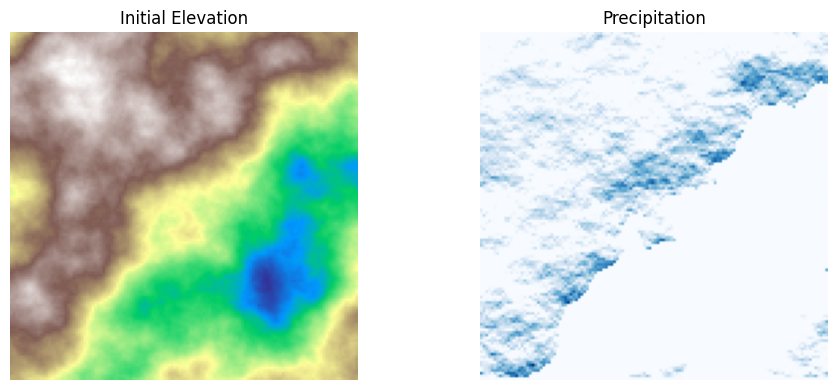

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (128,128) (128,4) (128,128) 

In [266]:
t = Tile(size=128, scale=0.012, coord=(0, 0), map_seed=(100, 100))
t.grid += np.abs(np.min(t.grid))

display_html(t)

WS = WaterSimulator(elevation=t.grid, wind_dir='south')

#break

N_steps = 100
plot_every = 10
for step_ in tqdm(range(N_steps)):
    WS.step()

    if step_ % plot_every == 0:
        WS.plot_current_state()
        #display(f"{np.mean(WS.elevation):.2f}; Range: [{np.min(WS.elevation):.2f}, {np.max(WS.elevation):.2f}]")
        #display_png(WS)

WS.plot_current_state()


In [242]:
3989/(512*512)


0.015216827392578125